# 2018-11-09 : LIP Spiking Network
# 1/ Match

In [1]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution, NumpyRNG

/home/hugo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.6/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DictError in SLIInterpreter::execute: Key '/Install' does not exist in dictionary.
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [2]:
neuron_parameters = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -65.5, #mV - McCormick
                 'v_thresh': -52.5, #mV - McCormick
                    }
N_pop = 1

In [3]:
sim.setup()

M_NM = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Match/NonMatch")

I = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Constant Inhibitor")

Test_A = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Test A")
Test_B = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Test B")

Sample_A = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Sample A")
Sample_B = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Sample B")

Inter_A = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Inter A")
Inter_B = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Inter B")

In [4]:
one_connector = sim.OneToOneConnector() 

static_syn = sim.StaticSynapse(weight = .5, delay = 1)
low_static_syn = sim.StaticSynapse(weight = .15, delay = 1)
high_static_syn = sim.StaticSynapse(weight = 1., delay = 1)

#inhibitory
I_to_MNM = sim.Projection(I, M_NM,
                        connector=one_connector,
                        synapse_type=high_static_syn,
                        receptor_type='inhibitory',
                        label="I to MNM connection")

Ia_to_I = sim.Projection(Inter_A, I,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="Ia to I connection")
Ib_to_I = sim.Projection(Inter_B, I,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="Ib to I connection")

#priors (= test dans l'ancienne version)
TA_to_Ia = sim.Projection(Test_A, Inter_A,
                          connector=one_connector,
                        synapse_type=low_static_syn,
                        receptor_type='excitatory',
                        label="TA to Ia connection")

TB_to_Ib = sim.Projection(Test_B, Inter_B,
                        connector=one_connector,
                        synapse_type=low_static_syn,
                        receptor_type='excitatory',
                        label="TB to Ib connection")

#inputs
SA_to_MNM = sim.Projection(Sample_A, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to MNM connection")
SA_to_Ia = sim.Projection(Sample_A, Inter_A,
                        connector=one_connector,
                        synapse_type=low_static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")

SB_to_MNM = sim.Projection(Sample_B, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")
SB_to_Ib = sim.Projection(Sample_B, Inter_B,
                        connector=one_connector,
                        synapse_type=low_static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")

In [5]:
amp = .3
pulse = sim.DCSource(amplitude = amp, start = 1., stop = 980.)
pulse.inject_into(Test_A)

pulse2 = sim.DCSource(amplitude = amp, start = 150., stop = 600.)
pulse2.inject_into(Sample_A)

pulse3 = sim.DCSource(amplitude = amp*1.2, start = .1, stop = 999.5)
pulse3.inject_into(I)

In [6]:
M_NM.record(['spikes', 'v'])
I.record(['spikes', 'v'])
Test_A.record(['spikes', 'v'])
Test_B.record(['spikes', 'v'])
Sample_A.record(['spikes', 'v'])
Sample_B.record(['spikes', 'v'])
Inter_A.record(['spikes', 'v'])
Inter_B.record(['spikes', 'v'])

simtime = 1000
sim.run(simtime)
sim.end()

In [7]:
import matplotlib.pyplot as plt

M_NM_data = M_NM.get_data()
M_NM_voltage = M_NM_data.filter(name='v')[0]

Test_A_data = Test_A.get_data()
Test_A_voltage = Test_A_data.filter(name='v')[0]
Test_B_data = Test_B.get_data()
Test_B_voltage = Test_B_data.filter(name='v')[0]

Sample_A_data = Sample_A.get_data()
Sample_A_voltage = Sample_A_data.filter(name='v')[0]
Sample_B_data = Sample_B.get_data()
Sample_B_voltage = Sample_B_data.filter(name='v')[0]


I_data = I.get_data()
I_voltage = I_data.filter(name='v')[0]

Inter_A_data = Inter_A.get_data()
Inter_A_voltage = Inter_A_data.filter(name='v')[0]
Inter_B_data = Inter_B.get_data()
Inter_B_voltage = Inter_B_data.filter(name='v')[0]

Text(0.5,1.03,'Match case (Prior and Sample are A)')

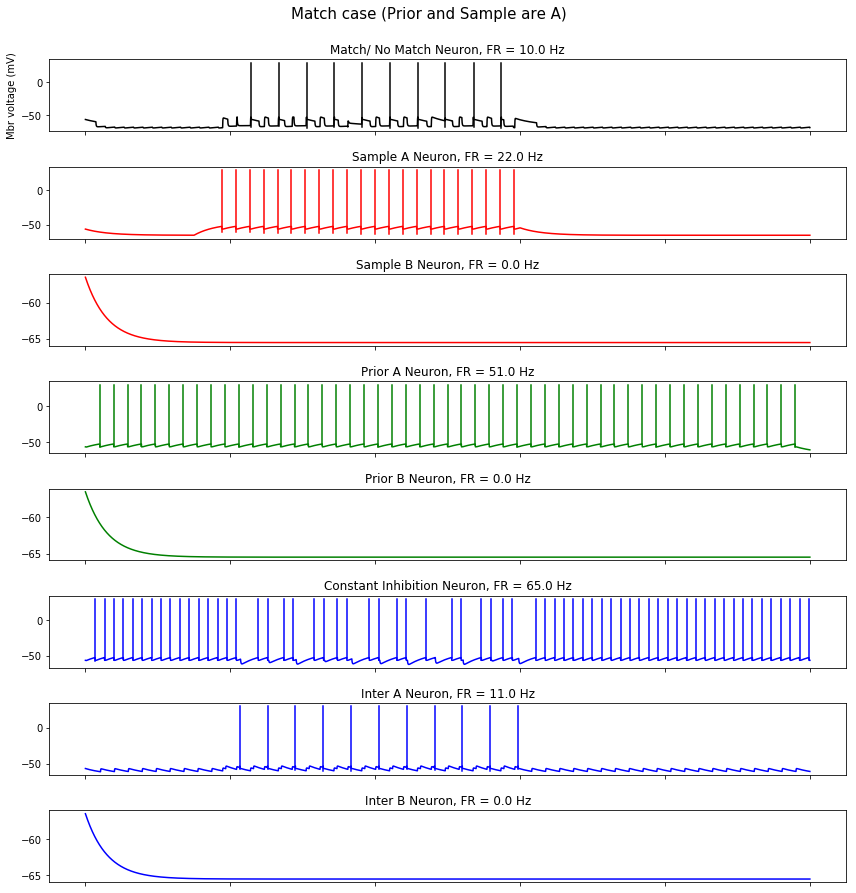

In [8]:
import numpy as np
fig, axs = plt.subplots(8, 1, figsize=(12, 12))

#Match Non Match
FR = len(M_NM_data.segments[0].spiketrains[0])/(simtime/1000)
axs[0].plot(M_NM_voltage, color='black')

for spikes in np.asarray(M_NM_data.segments[0].spiketrains[0]):
    axs[0].plot([spikes*10, spikes*10],
                [M_NM_voltage[int(spikes)], 30], color='black')
    
axs[0].set_title('Match/ No Match Neuron, FR = %s Hz' % FR)
axs[0].set_xticklabels([])
axs[0].set_ylabel('Mbr voltage (mV)')

#Sample A 
FR = len(Sample_A_data.segments[0].spiketrains[0])/(simtime/1000)
axs[1].plot(Sample_A_voltage, color='r')

for spikes in np.asarray(Sample_A_data.segments[0].spiketrains[0]):
    axs[1].plot([spikes*10, spikes*10],
                [Sample_A_voltage[int(spikes)], 30], color='r')
axs[1].set_title('Sample A Neuron, FR = %s Hz' % FR)
axs[1].set_xticklabels([])

#Sample B
FR = len(Sample_B_data.segments[0].spiketrains[0])/(simtime/1000)
axs[2].plot(Sample_B_voltage, color='r')

for spikes in np.asarray(Sample_B_data.segments[0].spiketrains[0]):
    axs[2].plot([spikes*10, spikes*10],
                [Sample_B_voltage[int(spikes)], 30], color='r')
axs[2].set_title('Sample B Neuron, FR = %s Hz' % FR)
axs[2].set_xticklabels([])


#Prior A
FR = len(Test_A_data.segments[0].spiketrains[0])/(simtime/1000)
axs[3].plot(Test_A_voltage, color='g')

for spikes in np.asarray(Test_A_data.segments[0].spiketrains[0]):
    axs[3].plot([spikes*10, spikes*10],
                [Test_A_voltage[int(spikes)], 30], color='g')
axs[3].set_title('Prior A Neuron, FR = %s Hz' % FR)
axs[3].set_xticklabels([])

#Prior B
FR = len(Test_B_data.segments[0].spiketrains[0])/(simtime/1000)
axs[4].plot(Test_B_voltage, color='g')

for spikes in np.asarray(Test_B_data.segments[0].spiketrains[0]):
    axs[4].plot([spikes*10, spikes*10],
                [Test_B_voltage[int(spikes)], 30], color='g')
axs[4].set_title('Prior B Neuron, FR = %s Hz' % FR)
axs[4].set_xticklabels([])

#Inter constant
FR = len(I_data.segments[0].spiketrains[0])/(simtime/1000)
axs[5].plot(I_voltage, color='b')

for spikes in np.asarray(I_data.segments[0].spiketrains[0]):
    axs[5].plot([spikes*10, spikes*10],
                [I_voltage[int(spikes)], 30], color='b')
axs[5].set_title('Constant Inhibition Neuron, FR = %s Hz' % FR)
axs[5].set_xticklabels([])

#Inter A
FR = len(Inter_A_data.segments[0].spiketrains[0])/(simtime/1000)
axs[6].plot(Inter_A_voltage, color='b')

for spikes in np.asarray(Inter_A_data.segments[0].spiketrains[0]):
    axs[6].plot([spikes*10, spikes*10],
                [Inter_A_voltage[int(spikes)], 30], color='b')
axs[6].set_title('Inter A Neuron, FR = %s Hz' % FR)
axs[6].set_xticklabels([])

#Inter B
FR = len(Inter_B_data.segments[0].spiketrains[0])/(simtime/1000)
axs[7].plot(Inter_B_voltage, color='b')

for spikes in np.asarray(Inter_B_data.segments[0].spiketrains[0]):
    axs[7].plot([spikes*10, spikes*10],
                [Inter_B_voltage[int(spikes)], 30], color='b')
axs[7].set_title('Inter B Neuron, FR = %s Hz' % FR)
axs[7].set_xticklabels([])

#axs[5].set_xticklabels([0, 0, 200, 400, 600, 800, 1000])
#axs[5].set_xlabel('Time (ms)')

plt.tight_layout()
plt.suptitle(x = .5, y = 1.03, t = 'Match case (Prior and Sample are A)', fontsize = 15)

# 2/ No Match

In [9]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution, NumpyRNG

In [10]:
neuron_parameters = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -65.5, #mV - McCormick
                 'v_thresh': -52.5, #mV - McCormick
                    }
N_pop = 1

In [11]:
sim.setup()

M_NM = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Match/NonMatch")

I = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Constant Inhibitor")

Test_A = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Test A")
Test_B = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Test B")

Sample_A = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Sample A")
Sample_B = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Sample B")

Inter_A = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Inter A")
Inter_B = sim.Population(N_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Inter B")

In [12]:
one_connector = sim.OneToOneConnector() 

static_syn = sim.StaticSynapse(weight = .5, delay = 1)
low_static_syn = sim.StaticSynapse(weight = .15, delay = 1)
high_static_syn = sim.StaticSynapse(weight = 1., delay = 1)

#inhibitory
I_to_MNM = sim.Projection(I, M_NM,
                        connector=one_connector,
                        synapse_type=high_static_syn,
                        receptor_type='inhibitory',
                        label="I to MNM connection")

Ia_to_I = sim.Projection(Inter_A, I,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="Ia to I connection")
Ib_to_I = sim.Projection(Inter_B, I,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='inhibitory',
                        label="Ib to I connection")

#priors (= test dans l'ancienne version)
TA_to_Ia = sim.Projection(Test_A, Inter_A,
                          connector=one_connector,
                        synapse_type=low_static_syn,
                        receptor_type='excitatory',
                        label="TA to Ia connection")

TB_to_Ib = sim.Projection(Test_B, Inter_B,
                        connector=one_connector,
                        synapse_type=low_static_syn,
                        receptor_type='excitatory',
                        label="TB to Ib connection")

#inputs
SA_to_MNM = sim.Projection(Sample_A, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to MNM connection")
SA_to_Ia = sim.Projection(Sample_A, Inter_A,
                        connector=one_connector,
                        synapse_type=low_static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")

SB_to_MNM = sim.Projection(Sample_B, M_NM,
                        connector=one_connector,
                        synapse_type=static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")
SB_to_Ib = sim.Projection(Sample_B, Inter_B,
                        connector=one_connector,
                        synapse_type=low_static_syn,
                        receptor_type='excitatory',
                        label="SA to Ia connection")

In [13]:
amp = .3
pulse = sim.DCSource(amplitude = amp, start = 1., stop = 980.)
pulse.inject_into(Test_B)

pulse2 = sim.DCSource(amplitude = amp, start = 150., stop = 600.)
pulse2.inject_into(Sample_A)

pulse3 = sim.DCSource(amplitude = amp*1.2, start = .1, stop = 999.5)
pulse3.inject_into(I)

In [14]:
M_NM.record(['spikes', 'v'])
I.record(['spikes', 'v'])
Test_A.record(['spikes', 'v'])
Test_B.record(['spikes', 'v'])
Sample_A.record(['spikes', 'v'])
Sample_B.record(['spikes', 'v'])
Inter_A.record(['spikes', 'v'])
Inter_B.record(['spikes', 'v'])

simtime = 1000
sim.run(simtime)
sim.end()

In [15]:
import matplotlib.pyplot as plt

M_NM_data = M_NM.get_data()
M_NM_voltage = M_NM_data.filter(name='v')[0]

Test_A_data = Test_A.get_data()
Test_A_voltage = Test_A_data.filter(name='v')[0]
Test_B_data = Test_B.get_data()
Test_B_voltage = Test_B_data.filter(name='v')[0]

Sample_A_data = Sample_A.get_data()
Sample_A_voltage = Sample_A_data.filter(name='v')[0]
Sample_B_data = Sample_B.get_data()
Sample_B_voltage = Sample_B_data.filter(name='v')[0]


I_data = I.get_data()
I_voltage = I_data.filter(name='v')[0]

Inter_A_data = Inter_A.get_data()
Inter_A_voltage = Inter_A_data.filter(name='v')[0]
Inter_B_data = Inter_B.get_data()
Inter_B_voltage = Inter_B_data.filter(name='v')[0]

Text(0.5,1.03,'No match case (Prior is B and sample is A)')

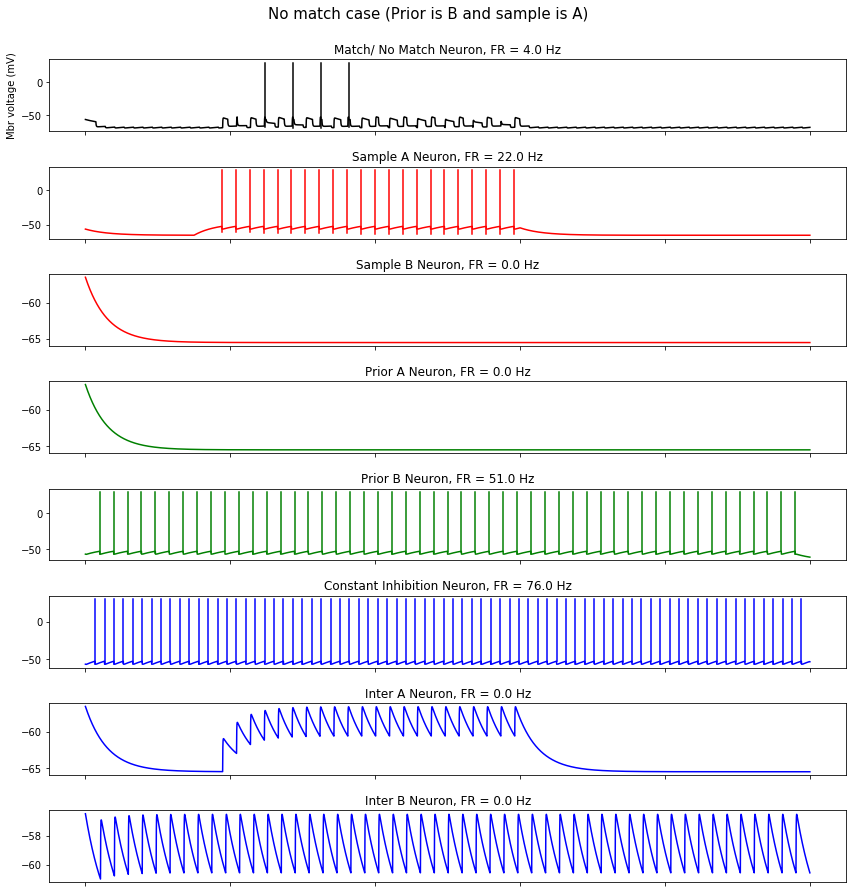

In [16]:
import numpy as np
fig, axs = plt.subplots(8, 1, figsize=(12, 12))

#Match Non Match
FR = len(M_NM_data.segments[0].spiketrains[0])/(simtime/1000)
axs[0].plot(M_NM_voltage, color='black')

for spikes in np.asarray(M_NM_data.segments[0].spiketrains[0]):
    axs[0].plot([spikes*10, spikes*10],
                [M_NM_voltage[int(spikes)], 30], color='black')
    
axs[0].set_title('Match/ No Match Neuron, FR = %s Hz' % FR)
axs[0].set_xticklabels([])
axs[0].set_ylabel('Mbr voltage (mV)')

#Sample A 
FR = len(Sample_A_data.segments[0].spiketrains[0])/(simtime/1000)
axs[1].plot(Sample_A_voltage, color='r')

for spikes in np.asarray(Sample_A_data.segments[0].spiketrains[0]):
    axs[1].plot([spikes*10, spikes*10],
                [Sample_A_voltage[int(spikes)], 30], color='r')
axs[1].set_title('Sample A Neuron, FR = %s Hz' % FR)
axs[1].set_xticklabels([])

#Sample B
FR = len(Sample_B_data.segments[0].spiketrains[0])/(simtime/1000)
axs[2].plot(Sample_B_voltage, color='r')

for spikes in np.asarray(Sample_B_data.segments[0].spiketrains[0]):
    axs[2].plot([spikes*10, spikes*10],
                [Sample_B_voltage[int(spikes)], 30], color='r')
axs[2].set_title('Sample B Neuron, FR = %s Hz' % FR)
axs[2].set_xticklabels([])


#Prior A
FR = len(Test_A_data.segments[0].spiketrains[0])/(simtime/1000)
axs[3].plot(Test_A_voltage, color='g')

for spikes in np.asarray(Test_A_data.segments[0].spiketrains[0]):
    axs[3].plot([spikes*10, spikes*10],
                [Test_A_voltage[int(spikes)], 30], color='g')
axs[3].set_title('Prior A Neuron, FR = %s Hz' % FR)
axs[3].set_xticklabels([])

#Prior B
FR = len(Test_B_data.segments[0].spiketrains[0])/(simtime/1000)
axs[4].plot(Test_B_voltage, color='g')

for spikes in np.asarray(Test_B_data.segments[0].spiketrains[0]):
    axs[4].plot([spikes*10, spikes*10],
                [Test_B_voltage[int(spikes)], 30], color='g')
axs[4].set_title('Prior B Neuron, FR = %s Hz' % FR)
axs[4].set_xticklabels([])

#Inter constant
FR = len(I_data.segments[0].spiketrains[0])/(simtime/1000)
axs[5].plot(I_voltage, color='b')

for spikes in np.asarray(I_data.segments[0].spiketrains[0]):
    axs[5].plot([spikes*10, spikes*10],
                [I_voltage[int(spikes)], 30], color='b')
axs[5].set_title('Constant Inhibition Neuron, FR = %s Hz' % FR)
axs[5].set_xticklabels([])

#Inter A
FR = len(Inter_A_data.segments[0].spiketrains[0])/(simtime/1000)
axs[6].plot(Inter_A_voltage, color='b')

for spikes in np.asarray(Inter_A_data.segments[0].spiketrains[0]):
    axs[6].plot([spikes*10, spikes*10],
                [Inter_A_voltage[int(spikes)], 30], color='b')
axs[6].set_title('Inter A Neuron, FR = %s Hz' % FR)
axs[6].set_xticklabels([])

#Inter B
FR = len(Inter_B_data.segments[0].spiketrains[0])/(simtime/1000)
axs[7].plot(Inter_B_voltage, color='b')

for spikes in np.asarray(Inter_B_data.segments[0].spiketrains[0]):
    axs[7].plot([spikes*10, spikes*10],
                [Inter_B_voltage[int(spikes)], 30], color='b')
axs[7].set_title('Inter B Neuron, FR = %s Hz' % FR)
axs[7].set_xticklabels([])

#axs[5].set_xticklabels([0, 0, 200, 400, 600, 800, 1000])
#axs[5].set_xlabel('Time (ms)')

plt.tight_layout()
plt.suptitle(x = .5, y = 1.03, t = 'No match case (Prior is B and sample is A)', fontsize = 15)